In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import pandas as pd
import pickle

# Exploratory Data Analysis

In [3]:
data_path = '/content/drive/My Drive/Fruit-Classification/data'

In [4]:
print('fruits number:', len(os.listdir(data_path)))

fruits number: 10


In [5]:
for fruit in os.listdir(data_path):
  print('{}: {} images'.format(fruit, len(os.listdir(data_path+'/'+fruit))))

pineapple: 250 images
tomato: 250 images
tangerine: 250 images
watermelon: 250 images
pear: 250 images
orange: 250 images
mango: 250 images
grape: 250 images
banana: 250 images
apple: 250 images


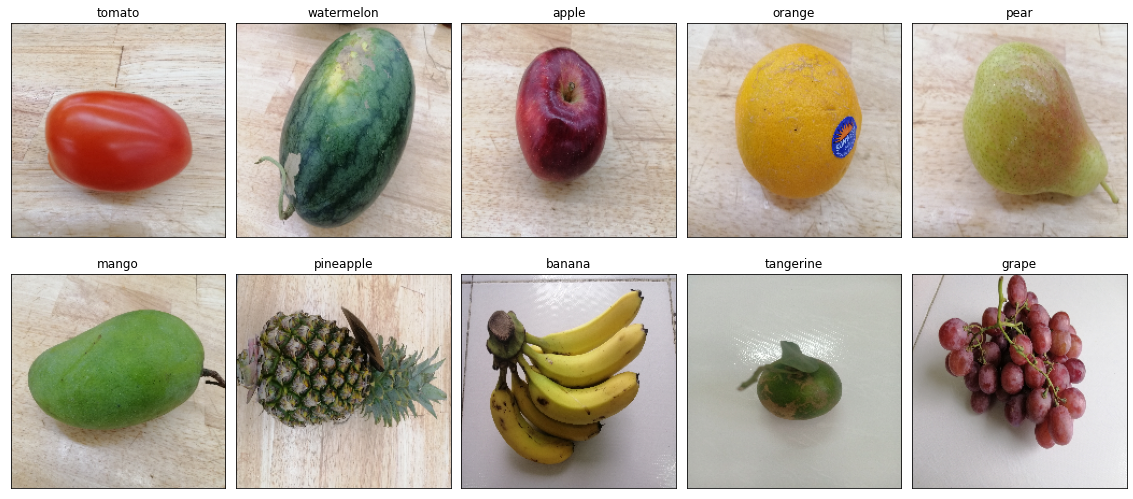

In [6]:
sample_images_path = '/content/drive/My Drive/Fruit-Classification/sample image'
sample_images = os.listdir(sample_images_path)
figure_size = 20
index = 1
plt.figure(figsize=(figure_size,figure_size))
for name in sample_images:
  img = cv2.imread(os.path.join(sample_images_path, name))
  img = cv2.resize(img,(200, 200))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  plt.subplot(2,5,index),plt.imshow(img)
  plt.title(name.split('_')[0]), plt.xticks([]), plt.yticks([])
    
  index+=1
plt.subplots_adjust(hspace=-0.7, wspace=0.05)


# Traditional ML: Feature Extraction

**Convert original image to an image has 2 colors using KMeans algorithm**

KMeans algorithm creates clusters based on the supplied count of clusters. In our case, it will form clusters of colors and these colors will be our top color. We then ```fit``` and ```predict``` on the same image to extract the prediction into the variable ```labels```.

* Convert the MxNx3 image into a Kx3 matrix where K=MxN and each row is now a vector in the 3-D space of RGB
```
# vectorized = img.reshape((-1,3))
```
* We convert the unit8 values to float as it is a requirement of the k-means method of OpenCV.
```
# vectorized = np.float32(vectorized)
```
* OpenCV provides [cv2.kmeans(sample,ncluster(k),criteria,attempts,flags)](https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html) function for color clustering.

  **1. samples:** It should be of np.float32 data type, and each feature should be put in a single column.

  **2. ncluster(K):** Number of clusters required at the end.

  **3. criteria:** It is the iteration termination criteria. When this criterion is satisfied, the algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `(type, max_iter, epsilon)`:

  Type of termination criteria. It has 3 flags as below:
    * **cv.TERM_CRITERIA_EPS** — stop the algorithm iteration if specified accuracy, epsilon, is reached.
    * **cv.TERM_CRITERIA_MAX_ITER** — stop the algorithm after the specified number of iterations, max_iter.
    * **cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER** — stop the iteration when any of the above condition is met.

  **4. attempts:** Flag to specify the number of times the algorithm is executed using different initial labelings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.

  **5. flags:** This flag used to specify how initial center are taken. Normally two flags are used for this:  **cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS**.

  ```
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  ```

* Now convert back into unit8.
```
center = np.uint8(center)
```
* Next, we need to access the labels to regenerate the clustered image.
```
res = center[label.flatten()]
result_image = res.reshape((img.shape))
```

The function below using code that was explain above.

**FUNCTION INPUT:** an image.

**FUNCTION OUTPUT:** a clustered image, two color in that image.

In [7]:
def clustering_image(img):
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))
  return result_image, center

Let's see how it work with our sample images.

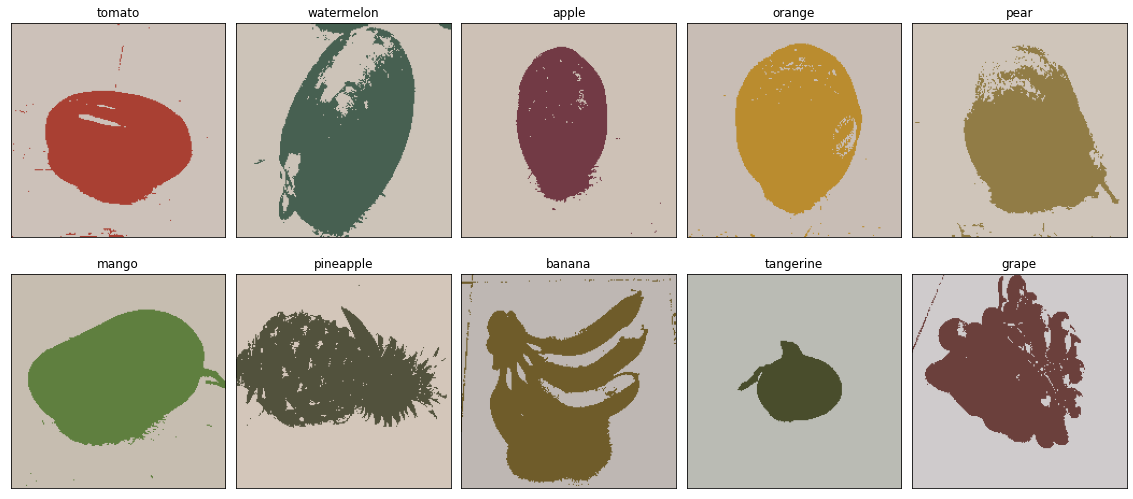

In [8]:
sample_images_path = '/content/drive/My Drive/Fruit-Classification/sample image'
sample_images = os.listdir(sample_images_path)
figure_size = 20
index = 1
plt.figure(figsize=(figure_size,figure_size))
for name in sample_images:
  img = cv2.imread(os.path.join(sample_images_path, name))
  img = cv2.resize(img,(200, 200))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # clustering image
  cluster_img, center_color= clustering_image(img)
  
  plt.subplot(2,5,index),plt.imshow(cluster_img)
  plt.title(name.split('_')[0]), plt.xticks([]), plt.yticks([])
    
  index+=1
plt.subplots_adjust(hspace=-0.7, wspace=0.05)


**Remove background color**

As we see, our image now has 2 color: fruit color and background color. To simplify these images, I'll remove background color by convert all pixel which has value RGB equal background color into 0.

We can see background color always is the brighter (for this dataset), I'll assume background color is brighter and remove the brighter color. 

* Find the brighter color
```
light_color = max(sum(center_color[0]), sum(center_color[1]))
```
* Any pixel in image has the value equal brighter color, I'll convert it into 0.
```
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if sum(img[x][y]) == light_color:
        img[x][y] = (0, 0, 0)
```

The function below using code that was explain above.

**FUNCTION INPUT:** a clustered image.

**FUNCTION OUTPUT:** a clustered image has only one color (removed background).

In [9]:
def remove_light_color(image, center_color):
  img = image.copy()
  light_color = max(sum(center_color[0]), sum(center_color[1]))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if sum(img[x][y]) == light_color:
        img[x][y] = (0, 0, 0)
    
  return img

Let's see how it work with our sample images.

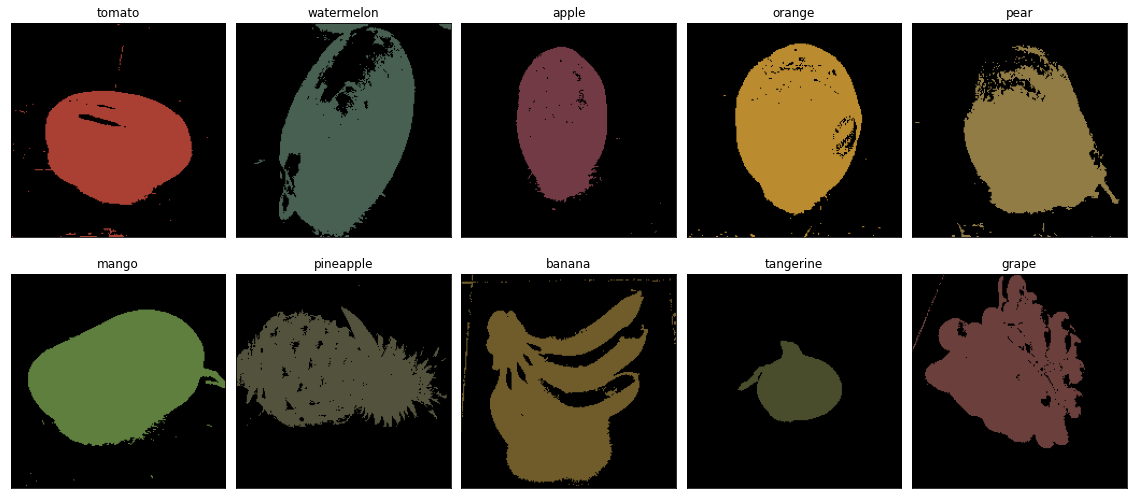

In [10]:
figure_size = 20
index = 1
plt.figure(figsize=(figure_size,figure_size))
for name in sample_images:
  img = cv2.imread(os.path.join(sample_images_path, name))
  img = cv2.resize(img,(200, 200))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cluster_img, center_color= clustering_image(img)
  final_img = remove_light_color(cluster_img, center_color)

  plt.subplot(2,5,index),plt.imshow(final_img)
  plt.title(name.split('_')[0]), plt.xticks([]), plt.yticks([])
    
  index+=1
plt.subplots_adjust(hspace=-0.7, wspace=0.05)


**Canny Edge**

I also decide to apply filter Canny Edge into our clustered image.



**FUNCTION INPUT:** a clustered image has only one color (removed background).

**FUNCTION OUTPUT:** a Canny Edge image.

In [11]:
def Canny_Detect(img):
    edge = cv2.Canny (img, 70, 50)
    return edge

Let's see how it work with our sample images.

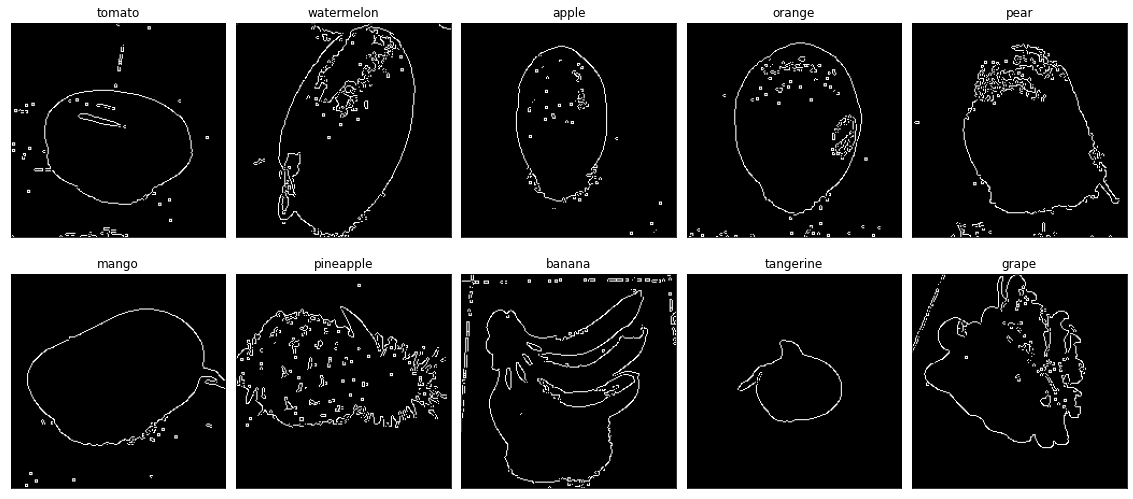

In [12]:
figure_size = 20
index = 1
plt.figure(figsize=(figure_size,figure_size))
for name in sample_images:
  img = cv2.imread(os.path.join(sample_images_path, name))
  img = cv2.resize(img,(200, 200))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  cluster_img, center_color= clustering_image(img)
  final_img = remove_light_color(cluster_img, center_color)
  edge_img = Canny_Detect(final_img)


  plt.subplot(2,5,index),plt.imshow(edge_img, cmap='gray')
  plt.title(name.split('_')[0]), plt.xticks([]), plt.yticks([])
    
  index+=1
plt.subplots_adjust(hspace=-0.7, wspace=0.05)


In [13]:
def show_image(name, number, fruit_img, cluster_img, final_img, edge_img):
  print('done {} images. {}'.format(number, name.upper()))
  figure_size = 10
  plt.figure(figsize=(figure_size,figure_size))

  plt.subplot(1,4,1),plt.imshow(fruit_img)
  plt.title('Original image'), plt.xticks([]), plt.yticks([])

  plt.subplot(1,4,2),plt.imshow(cluster_img)
  plt.title('Cluster image'), plt.xticks([]), plt.yticks([])

  plt.subplot(1,4,3),plt.imshow(final_img)
  plt.title('Final image'), plt.xticks([]), plt.yticks([])

  plt.subplot(1,4,4),plt.imshow(edge_img, cmap='gray')
  plt.title('Canny Edge'), plt.xticks([]), plt.yticks([])

  plt.show()

## Read, processing and split datasets

With all method we applied above,

done 250 images. TOMATO


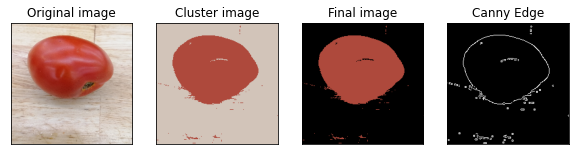

done 500 images. ORANGE


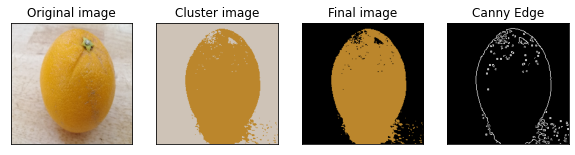

done 750 images. BANANA


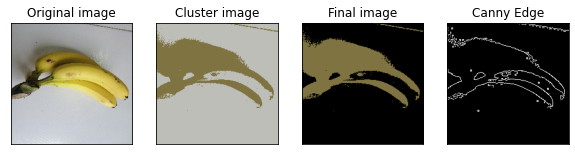

done 1000 images. WATERMELON


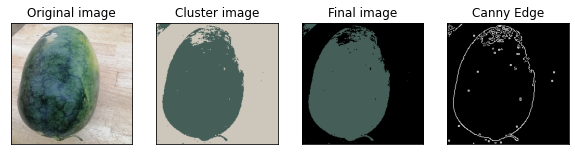

done 1250 images. PEAR


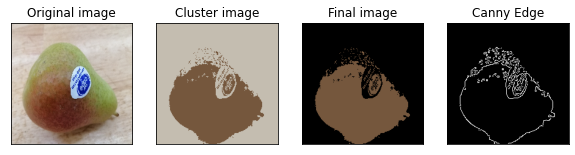

done 1500 images. GRAPE


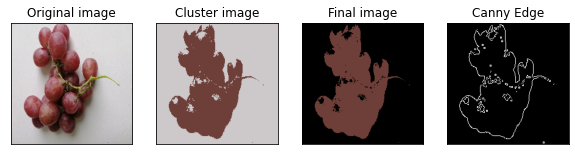

done 1750 images. TANGERINE


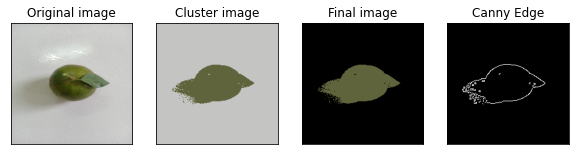

done 2000 images. APPLE


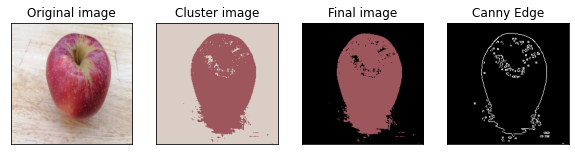

done 2250 images. PINEAPPLE


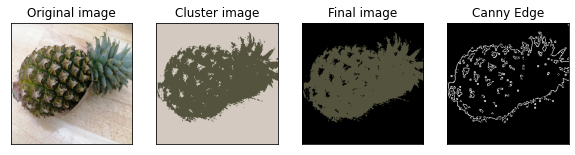

done 2500 images. MANGO


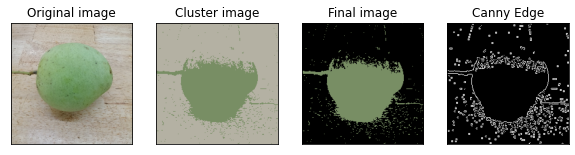

In [14]:
path = '/content/drive/My Drive/Fruit-Classification/data'
name_fruits = ['tomato', 'orange', 'banana', 'watermelon', 'pear', 'grape', 'tangerine', 'apple', 'pineapple', 'mango']
dataset_train = {}
dataset_test = {}
test_size = 0.25
number = 1

for name in name_fruits:
  index = 0
  images_train = []
  images_test = []
  while index < 250:
    img_path = path+'/'+name+'/'+name+'_'+str(index)+'.jpg'
    index+=1
    
    fruit_img = cv2.imread(img_path)
    fruit_img = cv2.resize(fruit_img, (200, 200))
    fruit_img = cv2.cvtColor(fruit_img,cv2.COLOR_BGR2RGB)

    cluster_img, center_color= clustering_image(fruit_img)

    final_img = remove_light_color(cluster_img, center_color)

    edge_img = Canny_Detect(final_img)
    
    if len(images_test) < test_size*(len(os.listdir(path+'/'+name))):
      images_test.append((final_img, edge_img))
    else:
      images_train.append((final_img, edge_img))
   
    if number%250==0:
      show_image(name, number, fruit_img, cluster_img, final_img, edge_img)

    number+=1
  dataset_train[name] = images_train
  dataset_test[name] = images_test

**Create dataframe with calculate the mean and standard deviation three channel color of clustered image that has only one color**

**FUNCTION INPUT:** the datasets

**FUNCTION OUTPUT:** a dataframe has 6 columns features and one columns for labels. And each row is an image.

In [15]:
def create_df_color(dataset):
  columns_name = ['name', 'red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std']
  
  red_means = []
  red_stds = []
  green_means = []
  green_stds = []
  blue_means = []
  blue_stds = []
  
  names = [] 

  for fruit in dataset:
    for images in dataset[fruit]:
      img = images[0]
      red_channel = img[:,:,0]
      green_channel = img[:,:,1]
      blue_channel = img[:,:,2]

      red_mean = np.mean(red_channel)
      green_mean = np.mean(green_channel)
      blue_mean = np.mean(blue_channel)
      
      red_std = np.std(red_channel)
      green_std = np.std(green_channel)
      blue_std = np.std(blue_channel)

      red_means.append(red_mean)
      red_stds.append(red_std)
      green_means.append(green_mean)
      green_stds.append(green_std)
      blue_means.append(blue_mean)
      blue_stds.append(blue_std)
      
      names.append(fruit)
      
  data = {'name': names, 'red_mean': red_means, 'red_std': red_stds, 'green_mean': green_means, 
          'green_std': green_stds, 'blue_mean': blue_means, 'blue_std': blue_stds}
  df = pd.DataFrame(data)
  return df

In [16]:
df_train_color = create_df_color(dataset_train)
df_test_color = create_df_color(dataset_test)

In [17]:
print(df_train_color.shape)
print(df_test_color.shape)
df_train_color.head()

(1870, 7)
(630, 7)


,name,red_mean,red_std,green_mean,green_std,blue_mean,blue_std
0,tomato,33.277300,58.750416,13.60240,24.014769,13.35950,23.585934
1,tomato,60.438400,83.572473,22.32100,30.864834,17.85680,24.691867
2,tomato,24.660350,54.021266,11.55415,25.310663,10.86435,23.799579
3,tomato,30.191525,62.843515,10.50140,21.858614,8.25110,17.174625
4,tomato,37.934325,63.131573,17.50815,29.137649,16.44705,27.371731


In [18]:
df_train_color.to_csv("/content/drive/My Drive/Fruit-Classification/input_output/df_train_color.csv", index=False)
df_test_color.to_csv("/content/drive/My Drive/Fruit-Classification/input_output/df_test_color.csv", index=False)

Create features name for each 40x40 pixels section.

In [19]:
def create_feature_name():
  feature_name = []
  section = 1
  for y in range(0, 200, 40):
      for x in range(0, 200, 40):
          feature_name.append(f"sec{section}_mean")
          feature_name.append(f"sec{section}_std")
          section += 1
  return feature_name

Calculate the mean and standard deviation each section 40x40 pixels

In [20]:
def features_grid(img):
    features = np.array([], dtype='uint8')
    section = 1
    
    for y in range(0, img.shape[0], 40):
        for x in range(0, img.shape[1], 40):
            section_img = img[y:y+40, x:x+40]
          
            section_mean = np.mean(section_img)
            section_std = np.std(section_img)
            
            features = np.append(features, [section_mean, section_std])
    
    return features

In [25]:
def create_df_edge(dataset):
  all_imgs = np.zeros((1, 50), dtype='uint8')

  name = []
  section_mean = []
  section_std = []
  for fruit in dataset: 
      for images in dataset[fruit]:
          img = images[1]
          img_features = features_grid(img)
          img_features = img_features.reshape(1, img_features.shape[0])

          all_imgs = np.append(all_imgs, img_features, axis=0)
          
          name.append (fruit)

  all_imgs = all_imgs[1:]
  feature_name = create_feature_name()
  df = pd.DataFrame(all_imgs, columns= feature_name)
  df.insert(loc = 0, column = "name", value= name)
  return df

In [27]:
df_train_edge = create_df_edge(dataset_train)
df_test_edge = create_df_edge(dataset_test)

In [28]:
print(df_train_edge.shape)
print(df_test_edge.shape)
df_train_edge.head()

(1870, 51)
(630, 51)


,name,sec1_mean,sec1_std,sec2_mean,sec2_std,sec3_mean,sec3_std,sec4_mean,sec4_std,sec5_mean,sec5_std,sec6_mean,sec6_std,sec7_mean,sec7_std,sec8_mean,sec8_std,sec9_mean,sec9_std,sec10_mean,sec10_std,sec11_mean,sec11_std,sec12_mean,sec12_std,sec13_mean,sec13_std,sec14_mean,sec14_std,sec15_mean,sec15_std,sec16_mean,sec16_std,sec17_mean,sec17_std,sec18_mean,sec18_std,sec19_mean,sec19_std,sec20_mean,sec20_std,sec21_mean,sec21_std,sec22_mean,sec22_std,sec23_mean,sec23_std,sec24_mean,sec24_std,sec25_mean,sec25_std
0,tomato,0.0,0.0,0.000000,0.000000,5.896875,38.326622,0.000000,0.000000,0.0,0.0,0.000000,0.000000,5.418750,36.775242,19.125000,67.164793,10.040625,49.593802,0.000000,0.000000,0.00000,0.000000,6.3750,39.811862,0.000,0.000000,6.375000,39.811862,0.00000,0.000000,0.0000,0.00000,9.562500,48.445806,0.000000,0.000000,9.721875,48.831990,0.000000,0.000000,0.00000,0.000000,1.753125,21.070677,9.88125,49.214628,4.143750,32.241054,0.00000,0.000000
1,tomato,0.0,0.0,1.115625,16.829728,10.518750,50.711312,3.346875,29.021570,0.0,0.0,2.709375,26.144787,7.490625,43.058099,13.387500,56.873433,13.228125,56.552529,3.506250,29.695117,14.98125,59.964831,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,6.37500,39.811862,0.0000,0.00000,9.403125,48.055989,3.506250,29.695117,9.243750,47.662452,2.550000,25.372180,4.14375,32.241054,25.021875,75.858315,41.43750,94.071760,4.303125,32.844786,0.00000,0.000000
2,tomato,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,6.534375,40.293518,10.040625,49.593802,4.940625,35.148963,0.000000,0.000000,0.00000,0.000000,6.3750,39.811862,0.000,0.000000,6.375000,39.811862,0.00000,0.000000,0.0000,0.00000,6.375000,39.811862,6.534375,40.293518,10.518750,50.711312,3.825000,30.995877,0.00000,0.000000,0.637500,12.734053,4.78125,34.588414,0.000000,0.000000,0.00000,0.000000
3,tomato,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.534375,40.293518,0.00000,0.000000,8.2875,45.217583,6.375,39.811862,6.375000,39.811862,1.59375,20.096423,4.4625,33.43686,6.693750,40.768860,0.000000,0.000000,8.446875,45.635550,0.000000,0.000000,7.01250,41.701467,8.606250,46.049172,10.20000,49.969591,5.100000,35.700000,0.00000,0.000000
4,tomato,0.0,0.0,0.000000,0.000000,6.853125,41.238108,4.143750,32.241054,0.0,0.0,0.000000,0.000000,4.303125,32.844786,10.996875,51.800308,14.503125,59.058922,0.637500,12.734053,0.00000,0.000000,6.3750,39.811862,0.000,0.000000,0.796875,14.232643,6.37500,39.811862,0.0000,0.00000,4.143750,32.241054,3.187500,28.331120,6.375000,39.811862,0.796875,14.232643,0.00000,0.000000,0.000000,0.000000,10.51875,50.711312,6.693750,40.768860,2.23125,23.748479


In [30]:
df_train_edge.to_csv("/content/drive/My Drive/Fruit-Classification/input_output/df_train_edge.csv", index=False)
df_test_edge.to_csv("/content/drive/My Drive/Fruit-Classification/input_output/df_test_edge.csv", index=False)